In [18]:
import numpy as np
import pandas as pd
import requests
import json
from bs4 import BeautifulSoup
import string
from scipy import spatial
from sklearn.feature_extraction.text import TfidfVectorizer

import random

In [19]:
#Read-in data from Austin's S3 bucket
url = 'https://austin-schaffer.s3.amazonaws.com/virginia-town-hall/scraped-public-comments/2022+Virginia+Public+Schools+Model+Policy+Public+Comments.csv'
comments = pd.read_csv(url, delimiter='|')

In [20]:
#Looks at our comments file and view our variables:
comments.info()
len(comments)

#Remove duplicates:
#Comment out the below if you don't want to remove duplicates:
comments = comments[~comments["doc_content"].duplicated()]

#Look again after duplicates are removed:
comments.info()

#Save our csv
comments.to_csv('commentsfromS3.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71297 entries, 0 to 71296
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   doc_key       71297 non-null  object
 1   doc_label     71297 non-null  object
 2   doc_title     71294 non-null  object
 3   doc_content   71297 non-null  object
 4   doc_original  71297 non-null  object
 5   doc_date      71297 non-null  object
 6   doc_author    71284 non-null  object
dtypes: object(7)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 35911 entries, 0 to 71296
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   doc_key       35911 non-null  object
 1   doc_label     35911 non-null  object
 2   doc_title     35908 non-null  object
 3   doc_content   35911 non-null  object
 4   doc_original  35911 non-null  object
 5   doc_date      35911 non-null  object
 6   doc_author    35898 non-null  

In [21]:
#Randomly sample rows from our dataframe
#comments = comments.sample(frac = 0.25, random_state = 1)
comments.head(1)

,doc_key,doc_label,doc_title,doc_content,doc_original,doc_date,doc_author
0,https://townhall.virginia.gov/L/viewcomments.c...,not_applicable,Transgender,I am strongly opposed to any law that would ...,<!DOCTYPE html> <p>I am strongly opposed to ...,10/27/22 3:07 am,Frank McCullough


In [22]:
#View a transposed comment:
comments.head(1).T

,0
doc_key,https://townhall.virginia.gov/L/viewcomments.c...
doc_label,not_applicable
doc_title,Transgender
doc_content,I am strongly opposed to any law that would ...
doc_original,<!DOCTYPE html> <p>I am strongly opposed to ...
doc_date,10/27/22 3:07 am
doc_author,Frank McCullough


In [23]:
# Append the titles and context of the comment together, and remove unicode symbols
comments['doc_total'] = [str(i).replace('\xa0','')+str(j).replace('\xa0','') for i, j in zip(comments['doc_title'], comments['doc_content'])]

# Remove '<br>' from 'doc_total'
comments['doc_total'] = comments['doc_total'].str.replace('<br>', '')

# Remove "\xa0"
comments = comments.replace('\xa0', '', regex=True)

# Remove "br"
comments = comments.replace('br', '', regex=True)

In [24]:
comments['doc_total'][3]

'Strongly Oppose  I strongly oppose the non-evidence based policy. Dear friends are living in fear that these proposed changes will create unsafe spaces for their trans child, create new undue stress and anxiety when they’ve worked so hard to support gender-affirming care, and have a long-term impact on their mental health and overall well-being. '

In [25]:
comments['doc_content'][3]

'  I strongly oppose the non-evidence based policy. Dear friends are living in fear that these proposed changes will create unsafe spaces for their trans child, create new undue stress and anxiety when they’ve worked so hard to support gender-affirming care, and have a long-term impact on their mental health and overall well-being. '

## Managing the labeled data
### Load our labeled data

In [26]:
labels = pd.read_csv('2022 Virginia Public Schools Model Policy - Public Comments - 500 Row Sample - Labels.csv')
labels.head(1).T

,0
labeler,Austin
sentiment,Opposed
Ask the ACLU,False
url,https://townhall.virginia.gov/L/viewcomments.c...
title,Gov Youngkin’s proposed policy for public scho...
commenter,Anonymous (183585)
Our Notes,NaN
Unnamed: 7,NaN
Unnamed: 8,NaN
Unnamed: 9,NaN


### Build a training and test set by splitting the data in half

### Compile the comments

In [27]:
#comments2 = comments.sample(frac = 0.25, random_state = 1)
#comments2 = comments2[['doc_key', 'doc_total']] #Creates a df that only only contains "doc_key" and "doc_total"
#comments2['index'] = comments2.index #Adds a new column called "index" with the index of comments df
#comments2 = comments2.rename({'doc_key': 'url'}, axis=1) #Renames doc_key column to "url"
#labels_train = pd.merge(labels, comments2, on = 'url', how='inner') #Merges dfs

## Get indexes of training rows

In [28]:
#Randomly sample rows from our dataframe
#labels_train = labels_train.sample(frac = 0.25, random_state = 1)

In [29]:
#allindex = labels_train['index']
#opposeindex = labels_train[labels_train['sentiment']=='Opposed']['index']
#supportindex = labels_train[labels_train['sentiment']=='Support']['index']
#ambigindex = labels_train[labels_train['sentiment']=='Ambiguous']['index']

## Calculating document similarity

In [30]:
# Convert each comment to a TF-IDF vector
#https://stackoverflow.com/questions/8897593/how-to-compute-the-similarity-between-two-text-documents
#https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/)

#Randomly select 50% of our data, due to computational power issues (not enough storage on my computer)
#comments_sample = comments.sample(frac = 0.50, random_state = 1)
comments_sample = comments

# Reset the indices
comments_sample.reset_index(inplace=True, drop=True)

In [31]:
#Create TF-IDF matrix
vect = TfidfVectorizer(min_df=1,
                       stop_words="english",
                       ngram_range=(1,3))
tfidf = vect.fit_transform(comments_sample['doc_total']) 

In [32]:
pairwise_similarity = tfidf * tfidf.T #the time-consuming step

In [33]:
comments2 = comments_sample[['doc_key', 'doc_total']] #Creates a df that only only contains "doc_key" and "doc_total"
comments2['index'] = comments2.index #Adds a new column called "index" with the index of comments df
comments2 = comments2.rename({'doc_key': 'url'}, axis=1) #Renames doc_key column to "url"
labels_train = pd.merge(labels, comments2, on = 'url', how='inner') #Merges dfs

C:\Users\laura\AppData\Local\Temp\ipykernel_5648\69851859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments2['index'] = comments2.index #Adds a new column called "index" with the index of comments df


In [34]:
#Create index lists
allindex = labels_train['index']
opposeindex = labels_train[labels_train['sentiment']=='Opposed']['index']
supportindex = labels_train[labels_train['sentiment']=='Support']['index']
ambigindex = labels_train[labels_train['sentiment']=='Ambiguous']['index']

In [35]:
pairwise_similarity_oppose = pairwise_similarity[:,opposeindex]
pairwise_similarity_support = pairwise_similarity[:,supportindex]
pairwise_similarity_ambig = pairwise_similarity[:,ambigindex]

In [36]:
oppose_mean_similarity = [i[0,0] for i in pairwise_similarity_oppose.mean(axis=1)]
support_mean_similarity = [i[0,0] for i in pairwise_similarity_support.mean(axis=1)]
ambig_mean_similarity = [i[0,0] for i in pairwise_similarity_ambig.mean(axis=1)]

In [37]:
total_mean_similarity = [i + j + k for i, j, k in zip(oppose_mean_similarity, support_mean_similarity, ambig_mean_similarity)]
oppose_prob = [i/j for i, j in zip(oppose_mean_similarity, total_mean_similarity)]
support_prob = [i/j for i, j in zip(support_mean_similarity, total_mean_similarity)]
ambig_prob = [i/j for i, j in zip(ambig_mean_similarity, total_mean_similarity)]

C:\Users\laura\AppData\Local\Temp\ipykernel_5648\2579640722.py:2: RuntimeWarning: invalid value encountered in scalar divide
  oppose_prob = [i/j for i, j in zip(oppose_mean_similarity, total_mean_similarity)]
C:\Users\laura\AppData\Local\Temp\ipykernel_5648\2579640722.py:3: RuntimeWarning: invalid value encountered in scalar divide
  support_prob = [i/j for i, j in zip(support_mean_similarity, total_mean_similarity)]
C:\Users\laura\AppData\Local\Temp\ipykernel_5648\2579640722.py:4: RuntimeWarning: invalid value encountered in scalar divide
  ambig_prob = [i/j for i, j in zip(ambig_mean_similarity, total_mean_similarity)]


In [38]:
sentiment_predict = ['Opposed' if (i > j) & (i > k) else 'Support' if (j > i) & (j > k) else 'Ambiguous' for i,j,k in zip(oppose_prob, support_prob, ambig_prob)]

In [39]:
pd.Series(sentiment_predict).value_counts()

Opposed      18405
Support      16562
Ambiguous      944
Name: count, dtype: int64

In [40]:
8957 + 7706 + 1293
#Opposed:
8957/17956

0.4988304744932056

In [41]:
#Supportive:
7706/17956

0.42916016930274004

In [42]:
#Ambiguous:
1293/17956

0.07200935620405435

## Getting max similarity scores and full comments

In [43]:
pairwise_similarity_all = pairwise_similarity[:,allindex]

In [44]:
max_sim = pairwise_similarity_all.argmax(axis=1)

In [45]:
max_sim = [allindex[x[0]] for x in max_sim.tolist()]

In [46]:
pd.Series(max_sim).value_counts()

2324     1596
10880    1138
6989     1009
1154      993
5721      809
         ... 
13295       2
935         2
11920       1
8262        1
2185        1
Name: count, Length: 471, dtype: int64

In [47]:
comments_sample['oppose_prob'] = oppose_prob
comments_sample['support_prob'] = support_prob
comments_sample['ambig_prob'] = ambig_prob
comments_sample['sentiment_predict'] = sentiment_predict
comments_sample['max_sim'] = max_sim
comments_sample['index'] = comments_sample.index

In [48]:
matchdata = comments_sample[['index', 'doc_title', 'doc_key', 'sentiment_predict']]
matchdata = matchdata.rename({'index':'max_sim',
                              'doc_title':'match_title',
                              'doc_key':'match_key',
                              'sentiment_predict':'match_sentiment'}, axis=1)

In [49]:
labeleddata = pd.merge(comments_sample, matchdata,
        on = 'max_sim',
        how = 'inner')

In [50]:
labeleddata.head(1)

,doc_key,doc_label,doc_title,doc_content,doc_original,doc_date,doc_author,doc_total,oppose_prob,support_prob,ambig_prob,sentiment_predict,max_sim,index,match_title,match_key,match_sentiment
0,https://townhall.virginia.gov/L/viewcomments.c...,not_applicable,Transgender,I am strongly opposed to any law that would ...,<!DOCTYPE html> <p>I am strongly opposed to ...,10/27/223:07 am,Frank McCullough,Transgender I am strongly opposed to any law ...,0.443158,0.362651,0.194192,Opposed,803,0,Strongly Oppose,https://townhall.virginia.gov/L/viewcomments.c...,Opposed


## Test set evaluation

In [51]:
testdata = pd.read_csv('testset.csv')
testdata = testdata[['URL', 'Sentiment 1']]
testdata = testdata.rename({'URL': 'doc_key',
                           'Sentiment 1': 'testset_sentiment'}, axis=1)

testdata = pd.merge(labeleddata, testdata,
                   on = 'doc_key',
                   how = 'inner')

testdata['sentiment_correct'] = testdata['testset_sentiment'] == testdata['sentiment_predict']
testdata['sentiment_correct2'] = testdata['testset_sentiment'] == testdata['match_sentiment']

In [52]:
pd.Series(testdata['sentiment_correct']).value_counts()

sentiment_correct
True     205
False     34
Name: count, dtype: int64

In [53]:
pd.Series(testdata['sentiment_correct2']).value_counts()

sentiment_correct2
True     199
False     40
Name: count, dtype: int64

In [54]:
pd.crosstab(testdata['testset_sentiment'], testdata['sentiment_predict'])

sentiment_predict,Ambiguous,Opposed,Support
testset_sentiment,,,
Ambiguous,0,1,2
Opposed,2,115,25
Support,0,4,90


In [55]:
pd.crosstab(testdata['testset_sentiment'], testdata['match_sentiment'])

match_sentiment,Opposed,Support
testset_sentiment,,
Ambiguous,2,1
Opposed,120,22
Support,15,79


In [56]:
pd.crosstab(testdata['testset_sentiment'], testdata['match_sentiment'])

match_sentiment,Opposed,Support
testset_sentiment,,
Ambiguous,2,1
Opposed,120,22
Support,15,79


## Save labeled data

In [57]:
labeleddata.to_csv('labeledcommentsvdoe.csv')

## Thematic analysis

In [58]:
vect = TfidfVectorizer(min_df=1,
                       stop_words="english",
                       ngram_range=(1,3))

In [59]:
opposed_comments = labeleddata[labeleddata['sentiment_predict']=='Opposed']['doc_total']
support_comments = labeleddata[labeleddata['sentiment_predict']=='Support']['doc_total']
# No ambiguous. Should we include ambiguous?

In [60]:
opposed_comments = ' '.join(opposed_comments)
support_comments = ' '.join(support_comments)
total_comments = [opposed_comments, support_comments]

In [61]:
tfidf = vect.fit_transform(total_comments) 

In [62]:
scores  = pd.DataFrame(tfidf.toarray()).T

In [63]:
logic = [x > .001 or y > .001 for x, y in zip(scores[0], scores[1])]
scores = scores[logic]

In [64]:
tokens = vect.get_feature_names_out().tolist()
tokens = [t for t, l in zip(tokens, logic) if l]

In [65]:
scores['Word or phrase'] = tokens
scores = scores.rename({0:'Oppose Score',
                       1: 'Support Score'}, axis=1)
scores = scores[['Word or phrase','Oppose Score','Support Score']]
scores.head(5)

,Word or phrase,Oppose Score,Support Score
16,000,0.001395,0.000910
994,10,0.003734,0.002461
1370,100,0.002908,0.010982
1933,100 support,0.000079,0.005007
2586,11,0.001041,0.000910


In [84]:
scores.sort_values(['Oppose Score'], ascending=False).head(10)

,Word or phrase,Oppose Score,Support Score,Difference
1578943,trans,0.346001,0.037483,0.308519
1465503,students,0.316860,0.181097,0.135763
1003148,oppose,0.302260,0.024140,0.278120
1118479,policy,0.262724,0.129589,0.133135
238649,children,0.255040,0.324499,-0.069458
802275,kids,0.231775,0.059787,0.171987
1455101,strongly,0.196326,0.079219,0.117107
1588514,transgender,0.184928,0.097711,0.087218
1333018,school,0.170564,0.213331,-0.042767
1455749,strongly oppose,0.159914,0.008165,0.151749


In [85]:
scores.sort_values(['Support Score'], ascending=False).head(10)

,Word or phrase,Oppose Score,Support Score,Difference
1040296,parents,0.115386,0.398312,-0.282926
238649,children,0.255040,0.324499,-0.069458
1499315,support,0.088937,0.265480,-0.176543
1107079,policies,0.137729,0.242691,-0.104963
1333018,school,0.170564,0.213331,-0.042767
1465503,students,0.316860,0.181097,0.135763
1661509,virginia,0.087620,0.169532,-0.081912
1349016,schools,0.088819,0.168423,-0.079604
1292710,rights,0.113205,0.159447,-0.046242
945935,model,0.053350,0.156901,-0.103550


In [68]:
scores.to_csv('themesvdoe.csv', index=False)

In [69]:
scores['Difference'] = scores['Oppose Score'] - scores['Support Score']

In [86]:
scores.sort_values('Difference', ascending=False).head(10)

,Word or phrase,Oppose Score,Support Score,Difference
1578943,trans,0.346001,0.037483,0.308519
1003148,oppose,0.302260,0.024140,0.278120
802275,kids,0.231775,0.059787,0.171987
1455749,strongly oppose,0.159914,0.008165,0.151749
1465503,students,0.316860,0.181097,0.135763
1118479,policy,0.262724,0.129589,0.133135
1737071,youth,0.144685,0.018521,0.126164
1455101,strongly,0.196326,0.079219,0.117107
1070509,people,0.135960,0.036586,0.099374
1588514,transgender,0.184928,0.097711,0.087218


# Latent Dirichlet Allocation Analysis

In [71]:
from sklearn.decomposition import LatentDirichletAllocation 
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [72]:
lda_model=LatentDirichletAllocation(n_components=10,
                                    learning_method='online',
                                    random_state=42,
                                    max_iter=1) 
# n_components is the number of topics

lda_top=lda_model.fit_transform(tfidf)

print(lda_top.shape)  # (no_of_doc,no_of_topics)
print(lda_top)

sum=0
for i in lda_top[0]:
  sum=sum+i
print(sum)  #All values sum to 1

C:\Users\laura\anaconda3\Lib\site-packages\sklearn\decomposition\_lda.py:895: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)


(2, 10)
[[0.0406119  0.00181429 0.00181429 0.00181429 0.00181429 0.10866299
  0.00181429 0.00181429 0.8380251  0.00181429]
 [0.4640419  0.00212629 0.00212629 0.00212629 0.00212629 0.00212629
  0.0021263  0.00212629 0.00212629 0.51894777]]
1.0


In [73]:
# composition of doc 0 for eg
print("Document 0: ")
for i,topic in enumerate(lda_top[0]):
  print("Topic ",i,": ",topic*100,"%")

#Document 0 is predominantly composed of Topic 7, followed by Topic 8, 1, and 3

Document 0: 
Topic  0 :  4.061189896230095 %
Topic  1 :  0.1814287296608662 %
Topic  2 :  0.18142872421275996 %
Topic  3 :  0.18142864858874477 %
Topic  4 :  0.18142868973521925 %
Topic  5 :  10.86629867136269 %
Topic  6 :  0.18142888401420554 %
Topic  7 :  0.18142886853613627 %
Topic  8 :  83.80250997679238 %
Topic  9 :  0.1814289108669008 %


In [74]:
print(type(vect))

<class 'sklearn.feature_extraction.text.TfidfVectorizer'>


In [75]:
print(lda_model.components_)
print(lda_model.components_.shape)  # (no_of_topics*no_of_words)

#Fit or fit_transform on tfidf object
tfidf = vect.fit_transform(total_comments) 

# most important words for each topic
vocab = vect.get_feature_names_out()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp,
                          key= lambda x:x[1],
                          reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

[[0.87031956 0.81813107 0.81044173 ... 0.62674485 0.82013321 0.90901225]
 [0.73360849 0.83505099 0.81313675 ... 0.69838786 0.87367524 0.7688399 ]
 [0.78185723 0.6411591  0.86994529 ... 0.96116235 0.88248526 0.83791956]
 ...
 [0.87393529 0.72390468 0.79183282 ... 0.84213586 0.97753682 0.81935677]
 [0.93576287 0.94735077 0.79405275 ... 0.9576986  0.89394843 0.74851474]
 [0.94422019 0.92249212 0.93565915 ... 0.84358078 0.83907474 0.80106731]]
(10, 1745662)
Topic 0: 
spike trans need silenced continues thrive correlates biological gender respecting dignity safety 17 publicly schools join virginia lgbtqia organization teach beautiful don sad illegal 

Topic 1: 
phone writing board education consider 22 sep 2018 effeminate girls business ing mistreatment don tolerate matters concerning minor youth trans affirming banning abortions students pediatric 

Topic 2: 
determine children old parents discussion restrict backwards attempting children school students related kids belong personal footin

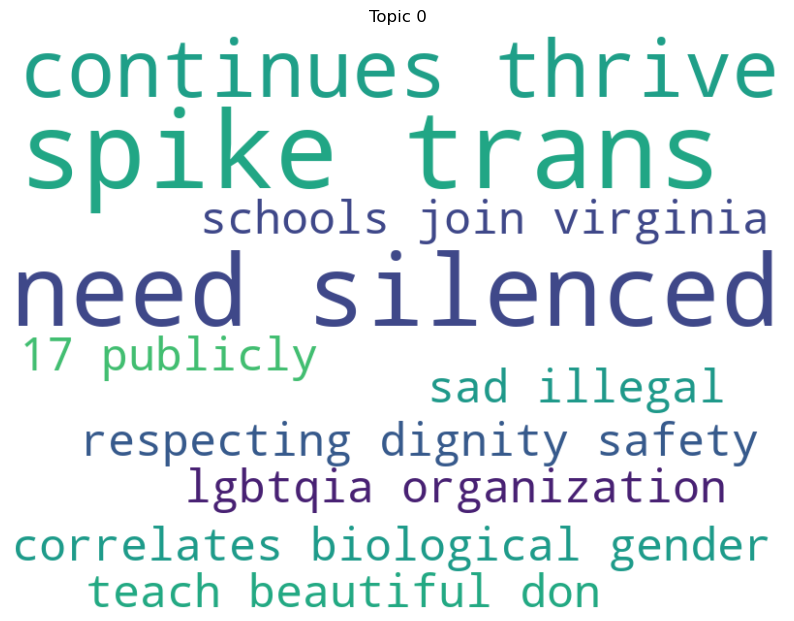

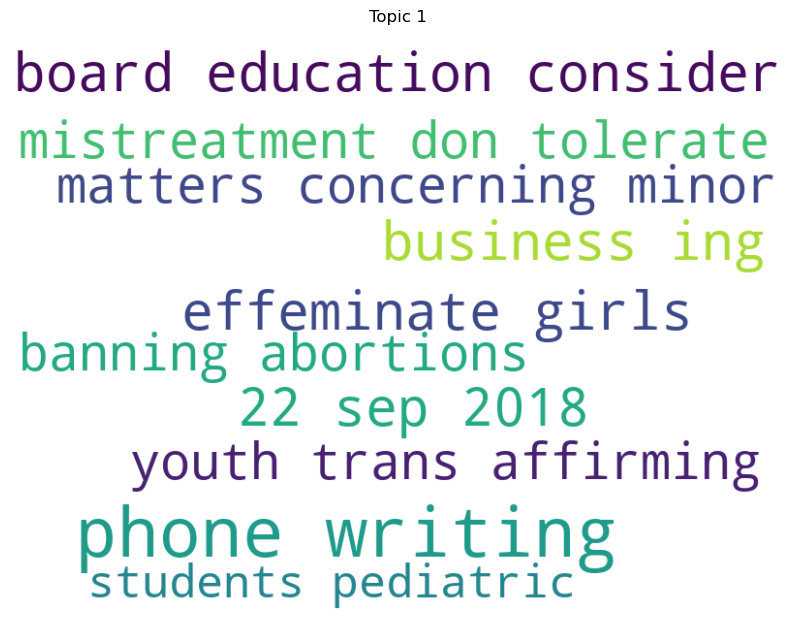

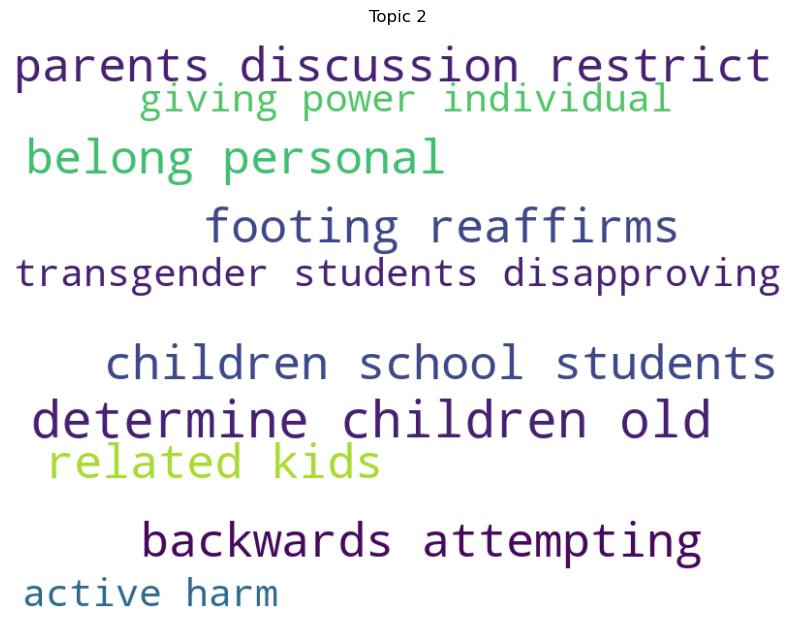

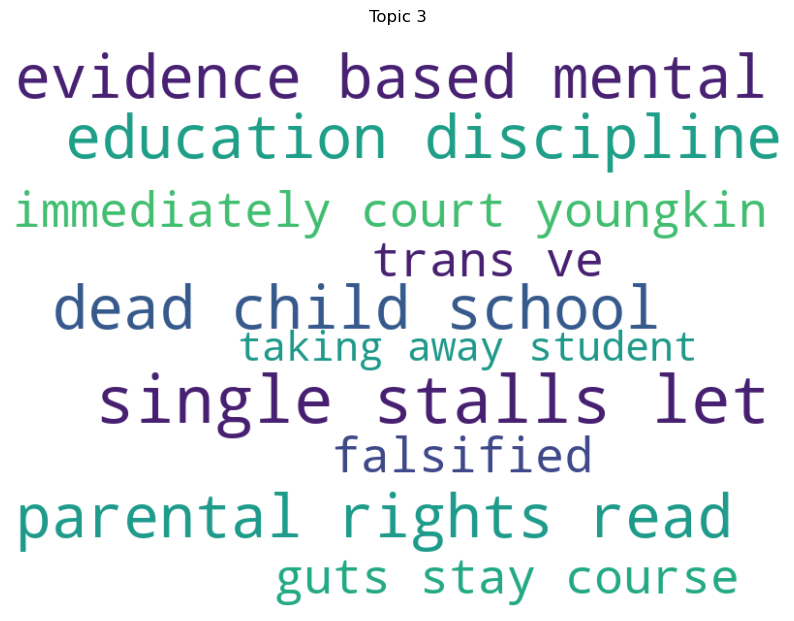

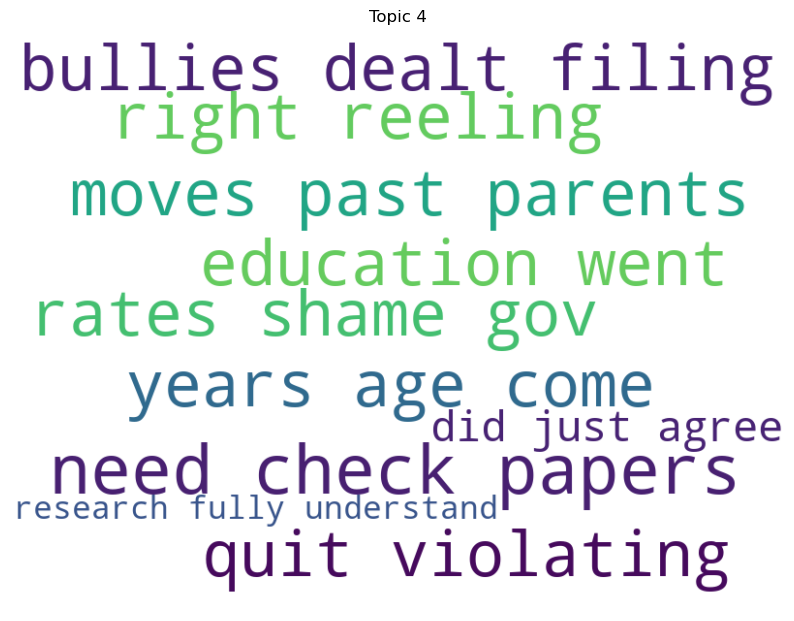

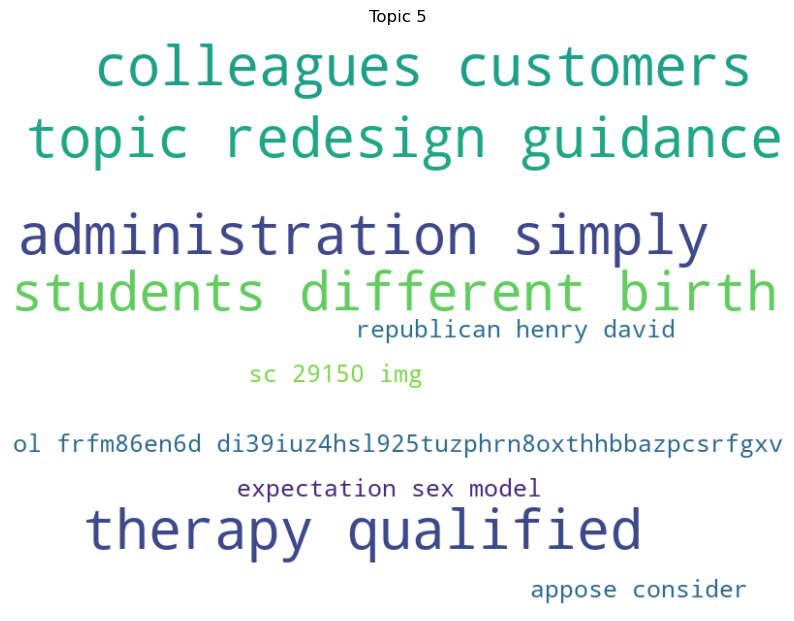

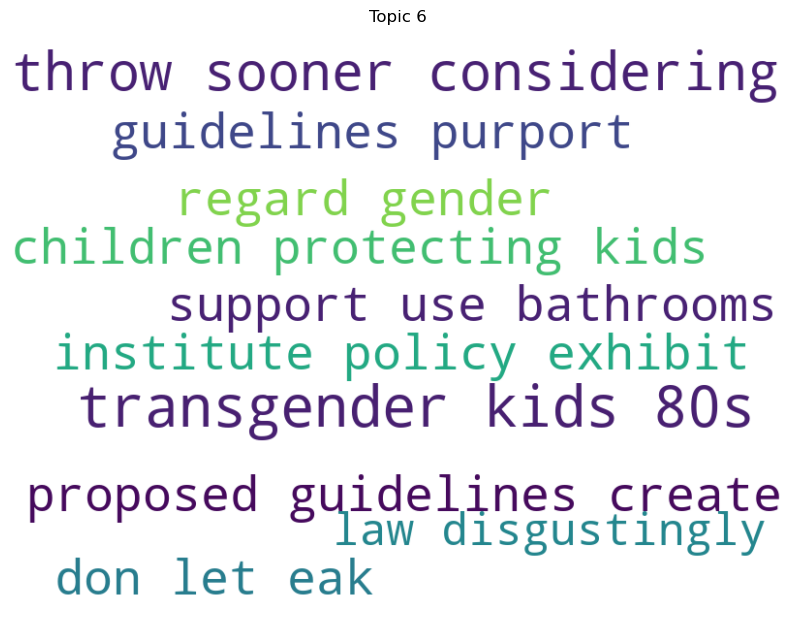

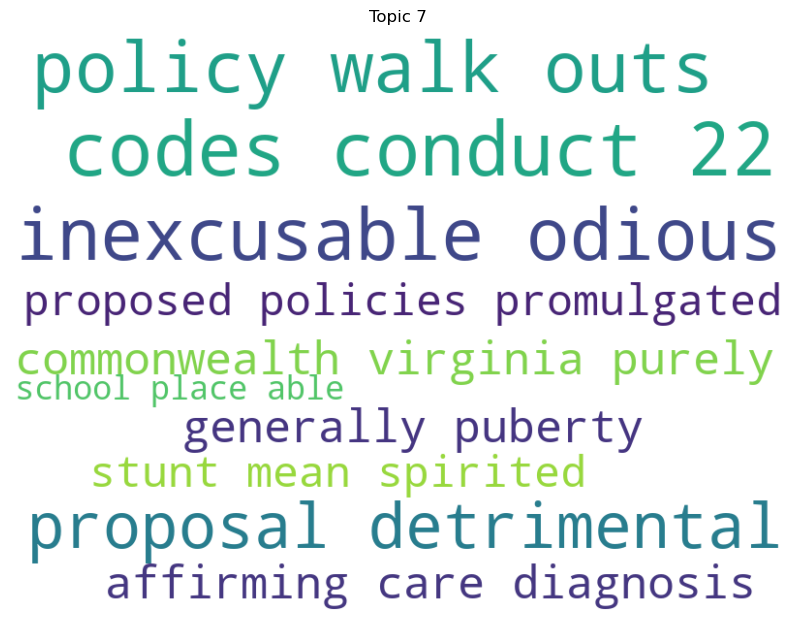

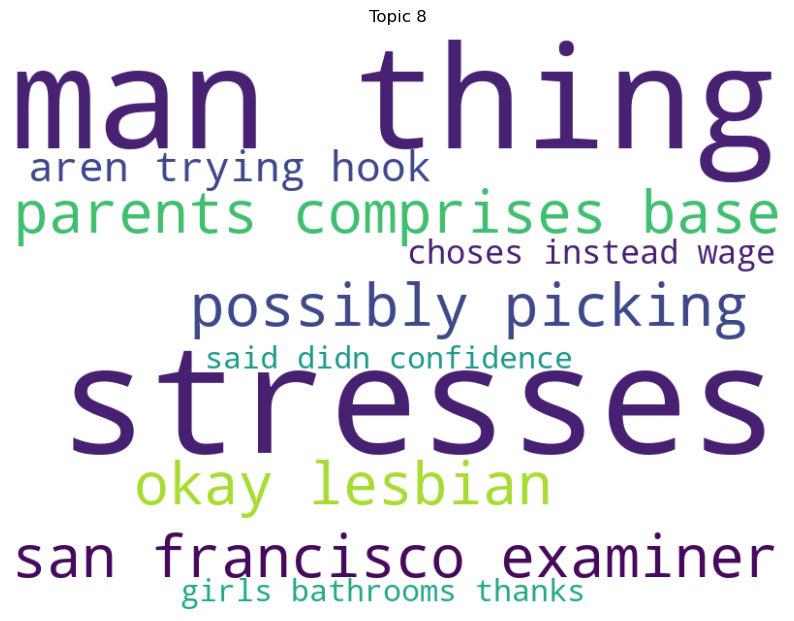

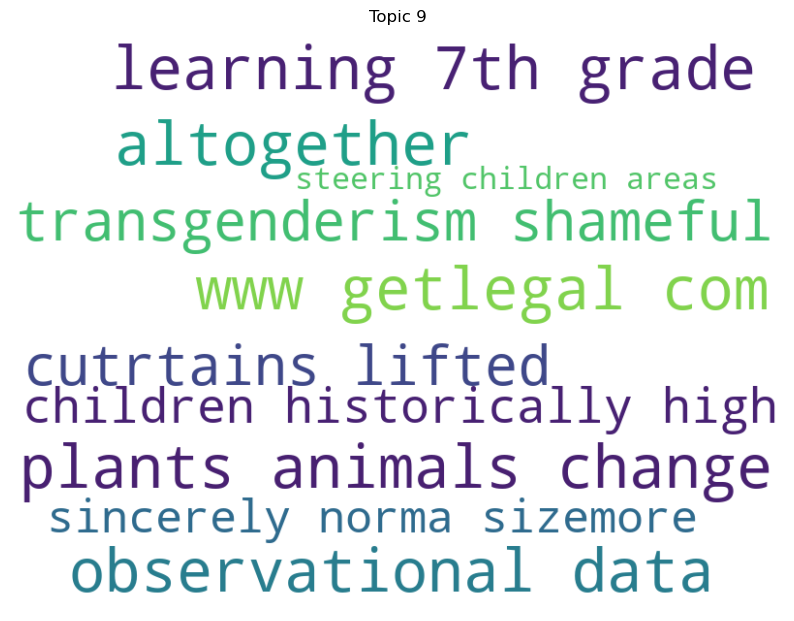

In [88]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create a word cloud for each topic
for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    
    # Generate a word cloud
    wc = WordCloud(width=800, height=600, random_state=42, max_words=2000, background_color='white')
    topic_words = {word: value for word, value in sorted_words}
    wc.generate_from_frequencies(topic_words)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title("Topic "+str(i))
    plt.show()

## Examine likely bots/duplicates and re-run TF-IDF

In [77]:
#Looks at our comments file and view our variables:
SCRAPED_COMMENTS_S3_URL = (
    "https://austin-schaffer.s3.amazonaws.com/virginia-town-hall/scraped-public-comments/"
    "2022+Virginia+Public+Schools+Model+Policy+Public+Comments.csv"
)
comments_raw = pd.read_csv(SCRAPED_COMMENTS_S3_URL, delimiter="|")

print(f"Length: {len(comments_raw.index)}")
comments_raw.head()

name_map = {
    "doc_key": "url",
    "doc_label": "label",
    "doc_title": "title",
    "doc_content": "content",
    "doc_original": "html_raw",
    "doc_date": "created_at",
    "doc_author": "author",
}

comments = comments_raw.rename(columns=name_map)
comments["created_at"] = pd.to_datetime(comments["created_at"])

comments.head()

Length: 71297


C:\Users\laura\AppData\Local\Temp\ipykernel_5648\2295907403.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  comments["created_at"] = pd.to_datetime(comments["created_at"])


,url,label,title,content,html_raw,created_at,author
0,https://townhall.virginia.gov/L/viewcomments.c...,not_applicable,Transgender,I am strongly opposed to any law that would ...,<!DOCTYPE html> <p>I am strongly opposed to ...,2022-10-27 03:07:00,Frank McCullough
1,https://townhall.virginia.gov/L/viewcomments.c...,not_applicable,"OPPOSE - this will cause actual, real, death o...","These kids are valid in their identities, ta...",<!DOCTYPE html> <p>These kids are valid in t...,2022-10-27 01:55:00,an APS student
2,https://townhall.virginia.gov/L/viewcomments.c...,not_applicable,"Consequences of Youngkin’s Policy Dire, Immediate",Gov. Youngkin's model policies regarding tra...,<!DOCTYPE html> <p>Gov. Youngkin's model pol...,2022-10-27 00:06:00,"Martha Molinaro, George Mason University"
3,https://townhall.virginia.gov/L/viewcomments.c...,not_applicable,Strongly Oppose,I strongly oppose the non-evidence based pol...,<!DOCTYPE html> <p>I <strong>strongly oppose...,2022-10-27 00:04:00,Anonymous (203044)
4,https://townhall.virginia.gov/L/viewcomments.c...,not_applicable,Opposed,"""Parents"" put a private equity sellout in ch...","<!DOCTYPE html> <p>""Parents"" put a private e...",2022-10-27 00:02:00,Anonymous (203041)


In [78]:
comment_id_regex = (
    r"^https://townhall.virginia.gov/L/viewcomments.cfm\?commentid=(\d+)$"
)
comments["id"] = comments["url"].str.extract(comment_id_regex)

comments.head()

,url,label,title,content,html_raw,created_at,author,id
0,https://townhall.virginia.gov/L/viewcomments.c...,not_applicable,Transgender,I am strongly opposed to any law that would ...,<!DOCTYPE html> <p>I am strongly opposed to ...,2022-10-27 03:07:00,Frank McCullough,203047
1,https://townhall.virginia.gov/L/viewcomments.c...,not_applicable,"OPPOSE - this will cause actual, real, death o...","These kids are valid in their identities, ta...",<!DOCTYPE html> <p>These kids are valid in t...,2022-10-27 01:55:00,an APS student,203046
2,https://townhall.virginia.gov/L/viewcomments.c...,not_applicable,"Consequences of Youngkin’s Policy Dire, Immediate",Gov. Youngkin's model policies regarding tra...,<!DOCTYPE html> <p>Gov. Youngkin's model pol...,2022-10-27 00:06:00,"Martha Molinaro, George Mason University",203045
3,https://townhall.virginia.gov/L/viewcomments.c...,not_applicable,Strongly Oppose,I strongly oppose the non-evidence based pol...,<!DOCTYPE html> <p>I <strong>strongly oppose...,2022-10-27 00:04:00,Anonymous (203044),203044
4,https://townhall.virginia.gov/L/viewcomments.c...,not_applicable,Opposed,"""Parents"" put a private equity sellout in ch...","<!DOCTYPE html> <p>""Parents"" put a private e...",2022-10-27 00:02:00,Anonymous (203041),203041


In [79]:
comments["full_text"] = comments["title"] + " " + comments["content"]
comments["full_text"] = comments["full_text"].replace("\xa0", "", regex=True).fillna("")
comments["full_text"] = comments["full_text"].str.replace('<br>', '', regex=True)
comments["full_text"] = comments["full_text"].str.replace('br', '', regex=True)

comments.head()

,url,label,title,content,html_raw,created_at,author,id,full_text
0,https://townhall.virginia.gov/L/viewcomments.c...,not_applicable,Transgender,I am strongly opposed to any law that would ...,<!DOCTYPE html> <p>I am strongly opposed to ...,2022-10-27 03:07:00,Frank McCullough,203047,Transgender I am strongly opposed to any law...
1,https://townhall.virginia.gov/L/viewcomments.c...,not_applicable,"OPPOSE - this will cause actual, real, death o...","These kids are valid in their identities, ta...",<!DOCTYPE html> <p>These kids are valid in t...,2022-10-27 01:55:00,an APS student,203046,"OPPOSE - this will cause actual, real, death o..."
2,https://townhall.virginia.gov/L/viewcomments.c...,not_applicable,"Consequences of Youngkin’s Policy Dire, Immediate",Gov. Youngkin's model policies regarding tra...,<!DOCTYPE html> <p>Gov. Youngkin's model pol...,2022-10-27 00:06:00,"Martha Molinaro, George Mason University",203045,"Consequences of Youngkin’s Policy Dire, Immedi..."
3,https://townhall.virginia.gov/L/viewcomments.c...,not_applicable,Strongly Oppose,I strongly oppose the non-evidence based pol...,<!DOCTYPE html> <p>I <strong>strongly oppose...,2022-10-27 00:04:00,Anonymous (203044),203044,Strongly Oppose I strongly oppose the non-ev...
4,https://townhall.virginia.gov/L/viewcomments.c...,not_applicable,Opposed,"""Parents"" put a private equity sellout in ch...","<!DOCTYPE html> <p>""Parents"" put a private e...",2022-10-27 00:02:00,Anonymous (203041),203041,"Opposed ""Parents"" put a private equity sello..."


In [80]:
#Deduplicated: We remove duplicated rows from our comments df:
comments_dedup = comments[~comments["content"].duplicated()]
len(comments_dedup)

#While Duplicates are not necessarily bots, it is an indication for us of political organization. 

#However, it will let us get an idea of the range of opinions if we de-duplicate our comments.

35911

In [81]:
#Deduplicated time stamps:
#This likely won't work; there's too many unique comments at the same time stamp to be likely bots
#comments_debot = comments[~comments["created_at"].duplicated()]
#len(comments_debot)

## Just Supportive Comments

In [87]:
print(lda_model.components_)
print(lda_model.components_.shape)  # (no_of_topics*no_of_words)

#Fit or fit_transform on tfidf object
tfidf = vect.fit_transform(support_comments) 

# most important words for each topic
vocab = vect.get_feature_names_out()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp,
                          key= lambda x:x[1],
                          reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

[[0.87031956 0.81813107 0.81044173 ... 0.62674485 0.82013321 0.90901225]
 [0.73360849 0.83505099 0.81313675 ... 0.69838786 0.87367524 0.7688399 ]
 [0.78185723 0.6411591  0.86994529 ... 0.96116235 0.88248526 0.83791956]
 ...
 [0.87393529 0.72390468 0.79183282 ... 0.84213586 0.97753682 0.81935677]
 [0.93576287 0.94735077 0.79405275 ... 0.9576986  0.89394843 0.74851474]
 [0.94422019 0.92249212 0.93565915 ... 0.84358078 0.83907474 0.80106731]]
(10, 1745662)


ValueError: Iterable over raw text documents expected, string object received.